In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import time
import datetime

In [2]:
df_1 = pd.read_csv('../input/berlin-airbnb-data/reviews_summary.csv')

print("The dataset has {} rows and {} columns.".format(*df_1.shape))

print("It contains {} duplicates.".format(df_1.duplicated().sum()))

The dataset has 401963 rows and 6 columns.
It contains 0 duplicates.


In [3]:
df_1.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2015,69544350,2016-04-11,7178145,Rahel,Mein Freund und ich hatten gute gemütliche vie...
1,2015,69990732,2016-04-15,41944715,Hannah,Jan was very friendly and welcoming host! The ...
2,2015,71605267,2016-04-26,30048708,Victor,Un appartement tres bien situé dans un quartie...
3,2015,73819566,2016-05-10,63697857,Judy,"It is really nice area, food, park, transport ..."
4,2015,74293504,2016-05-14,10414887,Romina,"Buena ubicación, el departamento no está orden..."


Well, it may be valuable to have more details, such as the latitude and longitude of the accommodation that has been reviewed, the neighbourhood it's in, the host id, etc. 

To get this information, let's **combine our reviews_dataframe** with the **listings_dataframe** and take only the columns we need from the latter one:

In [4]:
df_2 = pd.read_csv('../input/berlin-airbnb-data/listings_summary.csv')
df_2.head()


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,...,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2015,https://www.airbnb.com/rooms/2015,20181107122246,2018-11-07,Berlin-Mitte Value! Quiet courtyard/very central,Great location! 30 of 75 sq meters. This wood...,A+++ location! This „Einliegerwohnung“ is an e...,Great location! 30 of 75 sq meters. This wood...,none,It is located in the former East Berlin area o...,"This is my home, not a hotel. I rent out occas...","Close to U-Bahn U8 and U2 (metro), Trams M12, ...","Simple kitchen/cooking, refrigerator, microwav...",Always available,"No parties No events No pets No smoking, not e...",NaN,NaN,https://a0.muscache.com/im/pictures/260fd609-7...,NaN,2217,https://www.airbnb.com/users/show/2217,Ian,2008-08-18,"Key Biscayne, Florida, United States",Believe in sharing economy.,within an hour,96%,NaN,t,https://a0.muscache.com/im/pictures/21428a22-4...,https://a0.muscache.com/im/pictures/21428a22-4...,Mitte,4.0,4.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Berlin, Berlin, Germany",Mitte,Brunnenstr. Süd,...,2.0,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",NaN,$60.00,NaN,NaN,$200.00,$30.00,1,$28.00,4,1125,3 months ago,t,0,21,51,141,2018-11-07,118,2016-04-11,2018-10-28,93.0,10.0,9.0,10.0,10.0,10.0,9.0,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,4,3.76
1,2695,https://www.airbnb.com/rooms/2695,20181107122246,2018-11-07,Prenzlauer Berg close to Mauerpark,NaN,In the summertime we are spending most of our ...,In the summertime we are spending most of our ...,none,NaN,NaN,Within walking distance you'll find the S-Bahn...,Außer deinem Zimmer kannst du noch die Küche u...,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/97d4f6e8-1...,NaN,2986,https://www.airbnb.com/users/show/2986,Michael,2008-09-16,"Berlin, Berlin, Germany",Living with my wife in Berlin. Like travellin...,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/50434955-1...,https://a0.muscache.com/im/pictures/50434955-1...,Prenzlauer Berg,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Berlin, Berlin, Germany",NaN,Prenzlauer Berg Nordwest,...,1.0,Real Bed,"{Wifi,Kitchen,Elevator,Heating,Washer,Essentia...",NaN,$17.00,NaN,NaN,$0.00,$0.00,1,$0.00,2,40,7 weeks ago,t,0,0,0,0,2018-11-07,6,2018-07-04,2018-10-01,100.0,10.0,10.0,10.0,10.0,10.0,10.0,t,NaN,NaN,f,f,flexible,f,f,1,1.42
2,3176,https://www.airbnb.com/rooms/3176,20181107122246,2018-11-07,Fabulous Flat in great Location,This beautiful first floor apartment is situa...,1st floor (68m2) apartment on Kollwitzplatz/ P...,This beautiful first floor apartment is situa...,none,The neighbourhood is famous for its variety of...,We welcome FAMILIES and cater especially for y...,"We are 5 min walk away from the tram M2, whic...",The apartment will be entirely yours. We are c...,Feel free to ask any

In [5]:
df = pd.merge(df_1, df_2[['neighbourhood_group_cleansed', 'host_id', 'latitude',
                          'longitude', 'number_of_reviews', 'id', 'property_type']], 
              left_on='listing_id', right_on='id', how='left')

df.rename(columns = {'id_x':'id', 'neighbourhood_group_cleansed':'neighbourhood_group'}, inplace=True)
df.drop(['id_y'], axis=1, inplace=True)

In [6]:
df.head(3)

,listing_id,id,date,reviewer_id,reviewer_name,comments,neighbourhood_group,host_id,latitude,longitude,number_of_reviews,property_type
0,2015,69544350,2016-04-11,7178145,Rahel,Mein Freund und ich hatten gute gemütliche vie...,Mitte,2217,52.534537,13.402557,118,Guesthouse
1,2015,69990732,2016-04-15,41944715,Hannah,Jan was very friendly and welcoming host! The ...,Mitte,2217,52.534537,13.402557,118,Guesthouse
2,2015,71605267,2016-04-26,30048708,Victor,Un appartement tres bien situé dans un quartie...,Mitte,2217,52.534537,13.402557,118,Guesthouse


In [7]:
print("The dataset has {} rows and {} columns.".format(*df.shape))

The dataset has 401963 rows and 12 columns.


#### 2.1. Dealing with Missing Values
<a id='2.1. Dealing with Missing Values'></a>

In [8]:
df.isna().sum()

listing_id               0
id                       0
date                     0
reviewer_id              0
reviewer_name            0
comments               496
neighbourhood_group      0
host_id                  0
latitude                 0
longitude                0
number_of_reviews        0
property_type            0
dtype: int64

In [9]:
df.dropna(inplace=True)
df.isna().sum()

listing_id             0
id                     0
date                   0
reviewer_id            0
reviewer_name          0
comments               0
neighbourhood_group    0
host_id                0
latitude               0
longitude              0
number_of_reviews      0
property_type          0
dtype: int64

In [10]:
df.shape

(401467, 12)

In [11]:
# we use Python's langdetect 
from langdetect import detect

In [12]:
# write the function that detects the language
def language_detection(text):
    try:
        return detect(text)
    except:
        return None

In [13]:
%%time
df['language'] = df['comments'].apply(language_detection)

CPU times: user 58min 58s, sys: 22 s, total: 59min 20s
Wall time: 59min 37s


In [14]:
df.language.value_counts().head(10)

en    271826
de     77179
fr     16855
es     12174
it      4871
nl      3891
ru      2315
ko      1646
pt      1401
da      1362
Name: language, dtype: int64

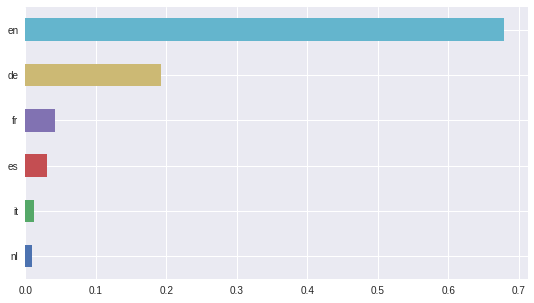

In [15]:
# visualizing the comments' languages a) quick and dirty
ax = df.language.value_counts(normalize=True).head(6).sort_values().plot(kind='barh', figsize=(9,5));

In [16]:
# splitting the dataframes in language related sub-dataframes
df_eng = df[(df['language']=='en')]
df_de  = df[(df['language']=='de')]
df_fr  = df[(df['language']=='fr')]

**Preparing Steps**

In [17]:
# import necessary libraries
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
from PIL import Image

import re
import string

In [18]:
# wrap the plotting in a function for easier access
def plot_wordcloud(wordcloud, language):
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.title(language + ' Comments\n', fontsize=18, fontweight='bold')
    plt.show()

**English WordCloud**

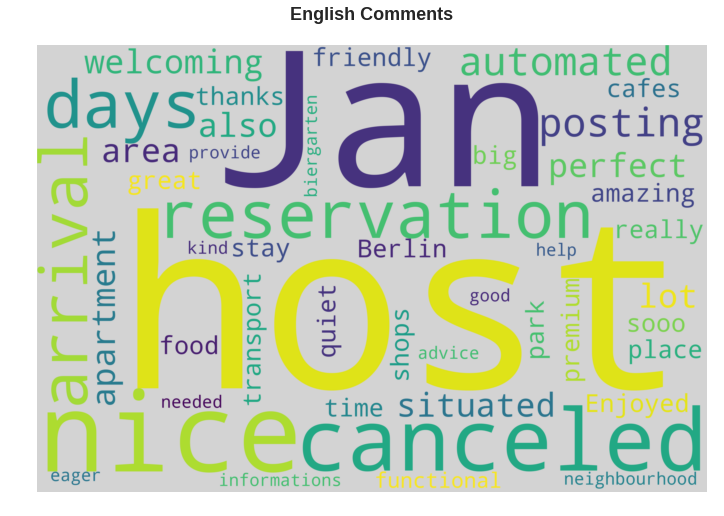

In [19]:
wordcloud = WordCloud(max_font_size=None, max_words=200, background_color="lightgrey", 
                      width=3000, height=2000,
                      stopwords=stopwords.words('english')).generate(str(df_eng.comments.values))

plot_wordcloud(wordcloud, 'English')

**German WordCloud**

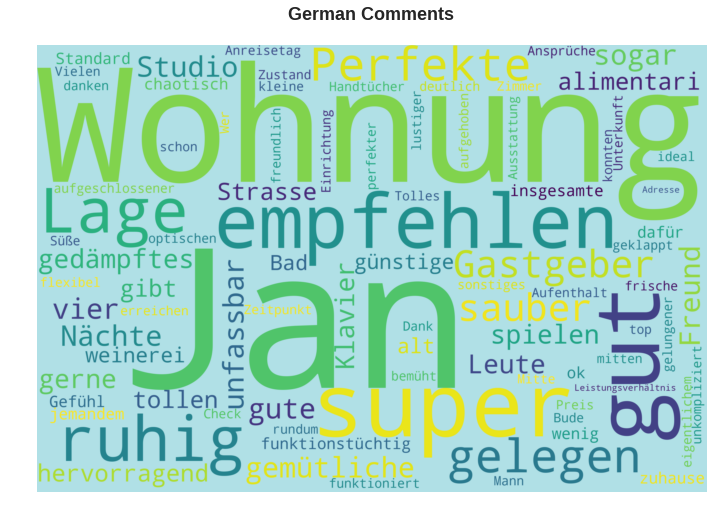

In [20]:
wordcloud = WordCloud(max_font_size=None, max_words=150, background_color="powderblue",
                      width=3000, height=2000,
                      stopwords=stopwords.words('german')).generate(str(df_de.comments.values))

plot_wordcloud(wordcloud, 'German')

**French WordCloud**

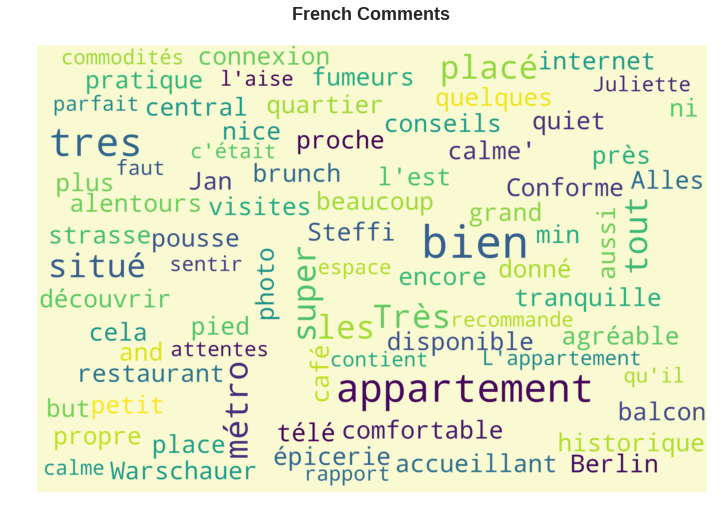

In [21]:
wordcloud = WordCloud(max_font_size=200, max_words=150, background_color="lightgoldenrodyellow",
                      #width=1600, height=800,
                      width=3000, height=2000,
                      stopwords=stopwords.words('french')).generate(str(df_fr.comments.values))

plot_wordcloud(wordcloud, 'French')

In [22]:
# load the SentimentIntensityAnalyser object in
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [23]:
# assign it to another name to make it easier to use
analyzer = SentimentIntensityAnalyzer()

In [24]:
# getting only the negative score
def negative_score(text):
    negative_value = analyzer.polarity_scores(text)['neg']
    return negative_value

# getting only the neutral score
def neutral_score(text):
    neutral_value = analyzer.polarity_scores(text)['neu']
    return neutral_value

# getting only the positive score
def positive_score(text):
    positive_value = analyzer.polarity_scores(text)['pos']
    return positive_value

# getting only the compound score
def compound_score(text):
    compound_value = analyzer.polarity_scores(text)['compound']
    return compound_value

In [25]:
%%time

df_eng['sentiment_neg'] = df_eng['comments'].apply(negative_score)
df_eng['sentiment_neu'] = df_eng['comments'].apply(neutral_score)
df_eng['sentiment_pos'] = df_eng['comments'].apply(positive_score)
df_eng['sentiment_compound'] = df_eng['comments'].apply(compound_score)

CPU times: user 15min 36s, sys: 3.01 s, total: 15min 39s
Wall time: 15min 44s


In [26]:
df_eng.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,neighbourhood_group,host_id,latitude,longitude,number_of_reviews,property_type,language,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_compound
1,2015,69990732,2016-04-15,41944715,Hannah,Jan was very friendly and welcoming host! The ...,Mitte,2217,52.534537,13.402557,118,Guesthouse,en,0.0,0.505,0.495,0.9703
3,2015,73819566,2016-05-10,63697857,Judy,"It is really nice area, food, park, transport ...",Mitte,2217,52.534537,13.402557,118,Guesthouse,en,0.0,0.530,0.470,0.7955
6,2015,76603178,2016-05-28,29323516,Laurent,"We had a very nice stay in Berlin, thanks to J...",Mitte,2217,52.534537,13.402557,118,Guesthouse,en,0.0,0.657,0.343,0.9779
7,2015,77296201,2016-05-31,9025122,Rasmus,"Great location close to Mauerpark, Kastanienal...",Mitte,2217,52.534537,13.402557,118,Guesthouse,en,0.0,0.727,0.273,0.8353
9,2015,82322683,2016-06-27,73902920,Mag,"Apartment very well located, close to everythi...",Mitte,2217,52.534537,13.402557,118,Guesthouse,en,0.0,0.811,0.189,0.8439


In [27]:
# full dataframe with POSITIVE comments
df_pos = df_eng.loc[df_eng.sentiment_compound >= 0.7]

# only corpus of POSITIVE comments
pos_comments = df_pos['comments'].tolist()

In [28]:
# full dataframe with POSITIVE comments
df_neg = df_eng.loc[df_eng.sentiment_compound < 0.0]

# only corpus of POSITIVE comments
neg_comments = df_neg['comments'].tolist()

*1. Cleaning and Preprocessing*

In [29]:
# importing libraries
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string

In [30]:
# prepare the preprocessing
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

In [31]:
# removing stopwords, punctuations and normalizing the corpus
def clean(doc):
    stop_free = " ".join([word for word in doc.lower().split() if word not in stop])
    punc_free = "".join(token for token in stop_free if token not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(comment).split() for comment in pos_comments] 

In [32]:
from gensim import corpora
dictionary = corpora.Dictionary(doc_clean)
corpus = [dictionary.doc2bow(text) for text in doc_clean]


In [33]:
import gensim

# let LDA find 3 topics
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=3, id2word=dictionary, passes=15)


topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.014*"u" + 0.011*"room" + 0.010*"apartment" + 0.010*"bed"')
(1, '0.026*"close" + 0.025*"apartment" + 0.022*"great" + 0.019*"place"')
(2, '0.039*"great" + 0.036*"place" + 0.029*"host" + 0.028*"stay"')


In [34]:
# now let LDA find 5 topics
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.036*"place" + 0.033*"nice" + 0.025*"really" + 0.025*"host"')
(1, '0.063*"great" + 0.037*"place" + 0.036*"apartment" + 0.036*"location"')
(2, '0.028*"u" + 0.013*"apartment" + 0.012*"even" + 0.008*"also"')
(3, '0.021*"room" + 0.016*"bed" + 0.015*"apartment" + 0.013*"kitchen"')
(4, '0.029*"station" + 0.025*"close" + 0.023*"minute" + 0.023*"walk"')


In [35]:
# and finally 10 topics
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=15)

topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.048*"great" + 0.044*"easy" + 0.036*"apartment" + 0.026*"location"')
(1, '0.084*"nice" + 0.043*"really" + 0.042*"place" + 0.035*"good"')
(2, '0.065*"great" + 0.048*"stay" + 0.047*"place" + 0.045*"would"')
(3, '0.044*"u" + 0.018*"even" + 0.015*"late" + 0.014*"check"')
(4, '0.092*"u" + 0.040*"home" + 0.031*"tip" + 0.029*"gave"')
(5, '0.120*"it’s" + 0.039*"located" + 0.030*"neat" + 0.029*"conveniently"')
(6, '0.034*"room" + 0.028*"bed" + 0.027*"kitchen" + 0.023*"bathroom"')
(7, '0.028*"restaurant" + 0.027*"apartment" + 0.023*"close" + 0.022*"station"')
(8, '0.022*"place" + 0.021*"berlin" + 0.018*"one" + 0.017*"airbnb"')
(9, '0.052*"berlin" + 0.042*"perfect" + 0.028*"day" + 0.028*"explore"')


*1. Cleaning and Preprocessing*

In [36]:
# calling the cleaning function we defined earlier
doc_clean = [clean(comment).split() for comment in neg_comments]

In [37]:
# create a dictionary from the normalized data, convert this to a bag-of-words corpus
dictionary = corpora.Dictionary(doc_clean)
corpus = [dictionary.doc2bow(text) for text in doc_clean]


In [38]:
# let LDA find 3 topics
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=3, id2word=dictionary, passes=15)

topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.019*"apartment" + 0.018*"place" + 0.010*"location" + 0.009*"berlin"')
(1, '0.013*"apartment" + 0.011*"u" + 0.011*"room" + 0.010*"host"')
(2, '0.015*"war" + 0.010*"und" + 0.009*"die" + 0.008*"e"')


In [39]:
# now let LDA find 5 topics
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.013*"host" + 0.013*"u" + 0.010*"place" + 0.009*"day"')
(1, '0.031*"apartment" + 0.009*"nice" + 0.008*"problem" + 0.008*"place"')
(2, '0.008*"berlin" + 0.008*"problem" + 0.007*"everything" + 0.007*"location"')
(3, '0.022*"war" + 0.014*"und" + 0.012*"die" + 0.012*"e"')
(4, '0.019*"room" + 0.017*"apartment" + 0.015*"place" + 0.011*"location"')


In [40]:
# and finally 10 topics
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=15)

topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.014*"room" + 0.012*"u" + 0.011*"bed" + 0.010*"place"')
(1, '0.019*"flat" + 0.013*"great" + 0.008*"bed" + 0.005*"clean"')
(2, '0.016*"dirty" + 0.016*"host" + 0.015*"day" + 0.012*"place"')
(3, '0.036*"war" + 0.024*"und" + 0.021*"die" + 0.016*"alles"')
(4, '0.028*"apartment" + 0.014*"u" + 0.013*"key" + 0.010*"host"')
(5, '0.012*"berlin" + 0.007*"reservation" + 0.005*"e" + 0.005*"è"')
(6, '0.019*"apartment" + 0.015*"flat" + 0.007*"clean" + 0.007*"window"')
(7, '0.031*"place" + 0.020*"room" + 0.017*"location" + 0.017*"good"')
(8, '0.019*"la" + 0.013*"de" + 0.010*"el" + 0.009*"que"')
(9, '0.013*"appartment" + 0.013*"nice" + 0.012*"flat" + 0.012*"water"')
